## Load and Clean Data

1. Both TE and gene data generated by UROMOL group is loaded into a pandas dataframe
2. Samples are ordered by there UROMOL ID ('U0001' -> 'U2122')
3. All simple repeat elements are eliminated
4. Elements with no expression in any sample were also removed

In [12]:
import pandas as pd
from Preprocessing.Funcs.ReorderUROMOL import UROMOLreorder

# load in both Gene and TE transcriptomic expression
Gene = pd.read_csv('~/Desktop/UROMOL-TE/UROMOL-Gene-RAW.csv', index_col='Unnamed: 0')
TE = pd.read_csv('~/Desktop/UROMOL-TE/UROMOL-TE-RAW.csv', index_col='Unnamed: 0')
RepName = pd.read_csv('~/Desktop/UROMOL-TE/TE-RepName.csv', index_col= 'Unnamed: 0', usecols=[0, 3])

# order the dataframe by UROMOL ID
IDs = []
for sample in TE.columns.tolist():
    IDs.append(int(sample.split('U')[1]))

TE = UROMOLreorder(IDs, TE)
Gene = UROMOLreorder(IDs, Gene)

# eliminate all simple repeat and unwanted elements from the TE dataset
TransposableClasses = ['LINE', 'SINE', 'LTR', 'DNA', 'Retroposon']
TENames = RepName[RepName['repClass'].isin(TransposableClasses)].index.values.tolist()
TE = TE.loc[TENames, :]

# remove all TE and Gene elements with no expression
TE = TE.loc[~(TE==0).all(axis=1)]
Gene = Gene.loc[~(Gene==0).all(axis=1)]

## PCA dimensional reduction

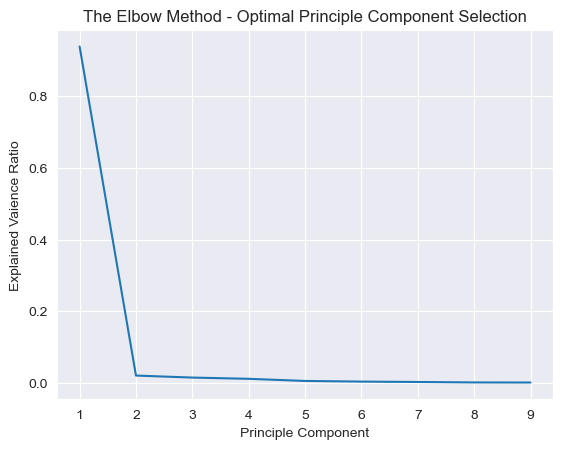

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

TEtransposed = TE.transpose()

MaximumPossiblePCs = 10

TEExplainedVarienceRatios = []

for i in range(1, MaximumPossiblePCs):
    model = PCA(n_components=i)
    TEfactorized = model.fit_transform(TEtransposed)
    TEExplainedVarienceRatios.append(model.explained_variance_ratio_[-1])

plt.plot(range(1, MaximumPossiblePCs), TEExplainedVarienceRatios)
plt.title('The Elbow Method - Optimal Principle Component Selection')
plt.xlabel('Principle Component')
plt.ylabel('Explained Vaience Ratio')
plt.show()

In [31]:
model = PCA(n_components=2)
TEfactorized = model.fit_transform(TEtransposed)
TEfactorized = pd.DataFrame(TEfactorized, columns=['PC1', 'PC2'])
print(TEfactorized.shape)
plt.scatter(TEfactorized['PC1'], TEfactorized['PC2'])

(535, 2)


## K-Means Clustering Analysis

1. Transpose TE dataframe
    - K-means clustering algorithm expects rows = sample, column = feature
2. Cluster count optimization (Elbow plot method)
    - Inertia is calculated as the sum of the squared distance from point to cluster centroid
    - MaximumPossibleClusterCount was arbitrarily set as an upper limit for possible cluster formation
        - Maximum is confirmed in elbow plot as k-means inertia is roughly equal from 5-9
    - The 'Elbow' is then selected as the point of maximum inflection (or has the largest f′′(x))
        - In my case this value is 3
2. Clustering Analysis with optimal cluster count

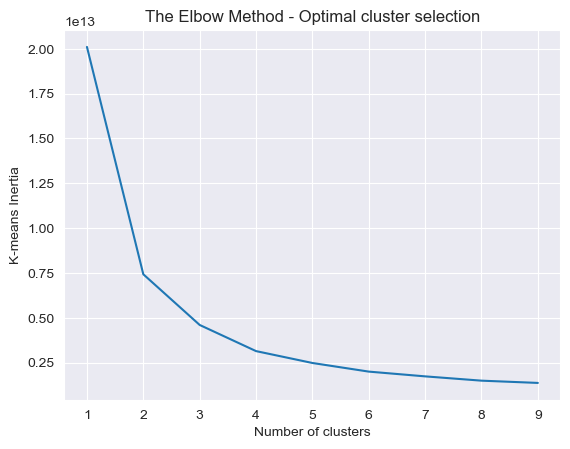

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

TEtransposed = TE.transpose()

MaximumPossibleClusterCount = 10

TEinertia = []

for i in range(1, MaximumPossibleClusterCount):
    model = KMeans(n_clusters=i, init='k-means++', random_state=0)
    TEfactorized = model.fit(TEtransposed)
    TEinertia.append(model.inertia_)

plt.plot(range(1, MaximumPossibleClusterCount), TEinertia)
plt.title('The Elbow Method - Optimal cluster selection')
plt.xlabel('Number of clusters')
plt.ylabel('K-means Inertia')
plt.show()

In [23]:
model = KMeans(n_clusters=3, init='k-means++', random_state=0)
TEfactorized = model.fit(TEtransposed)
TEtransposed['cluster'] = TEfactorized.labels_

535
